# Funnel dimension sweep

In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from matplotlib.animation import FuncAnimation

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd

import utils
import plot
import distributions
import models
import flows
from tqdm import tqdm
key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# set up exporting
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
    'pgf.rcfonts': False,
})

figure_path = "/home/lauro/documents/msc-thesis/thesis/figures/"
# save figures by using plt.savefig('path/to/fig')
# remember that latex textwidth is 5.4in
# so use figsize=[5.4, 4], for example
printsize = [5.4, 4]

# High-dim Funnel

In [29]:
n_steps = 200
particle_lr = 1e-2
learner_lr = 1e-2
n_particles = 200
d = 7

In [30]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)

In [31]:
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., patience=0, learner_lr=learner_lr)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

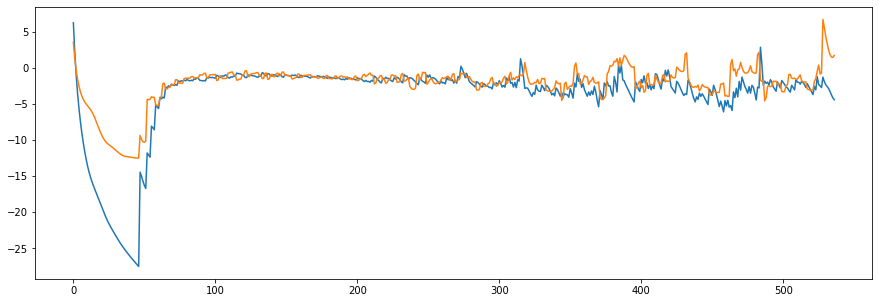

In [32]:
%matplotlib inline
plt.subplots(figsize=[15, 5])
plt.plot(neural_learner.rundata["training_loss"])
plt.plot(neural_learner.rundata["validation_loss"])

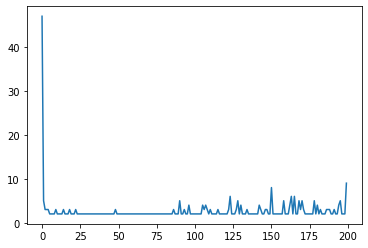

In [33]:
%matplotlib inline
plt.plot(neural_learner.rundata["train_steps"])

In [34]:
# get final particles
target_cov = target.cov
final_particles_list = []
for p in [neural_particles, svgd_particles, sgld_particles]:
    particles = p.get_params()
    final_particles_list.append(particles.training)
covs = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "sgld"]
neural_final, svgd_final, sgld_final = final_particles_list

In [39]:
def plot_projection(idx):
    true_samples = target.sample(1000)
    sample_list = [p.particles.training for p in (neural_particles, sgld_particles, svgd_particles)]
    fig, axs = plt.subplots(1, 3, figsize=[20, 5])
    titles = ("Neural SVGD", "Langevin", "SVGD")
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        print(samples.shape)
        ax.scatter(*np.rollaxis(true_samples[:, idx], 1), alpha=0.15, label="True")
        ax.scatter(*np.rollaxis(samples[:, idx], 1), alpha=0.15)
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

(200, 7)
(200, 7)
(200, 7)


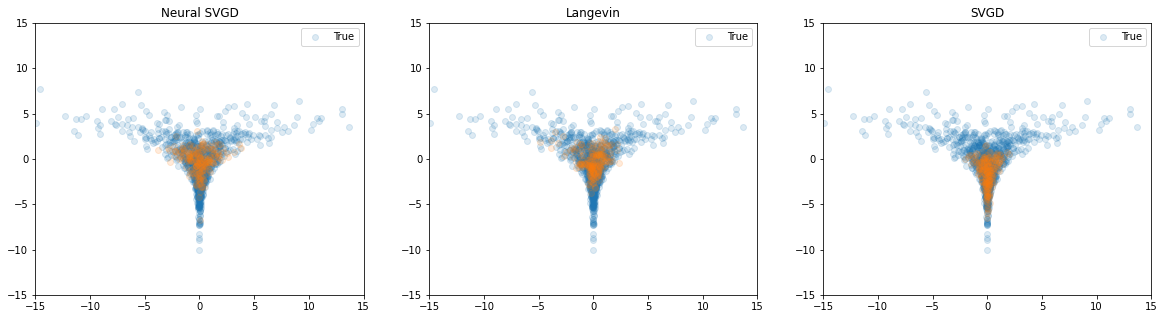

In [40]:
%matplotlib inline
lims=(-15, 15)
# def plot_projection(idx):
#     true_samples = target.sample(200)
#     sample_list = [p.particles.training for p in (neural_particles, sgld_particles, svgd_particles)]
#     fig, axs = plt.subplots(1, 3, figsize=[20, 5])
#     titles = ("Neural SVGD", "Langevin", "SVGD")
#     for samples, ax, title in zip(sample_list, axs.flatten(), titles):
#         ax.scatter(*np.rollaxis(samples[:, idx], 1))
#         ax.scatter(*np.rollaxis(true_samples[:, idx], 1), alpha=0.25, label="True")
#         ax.legend()
#         ax.set_title(title)
#         ax.set(xlim=lims, ylim=lims)

idx = np.array([0, -1])
plot_projection(idx)

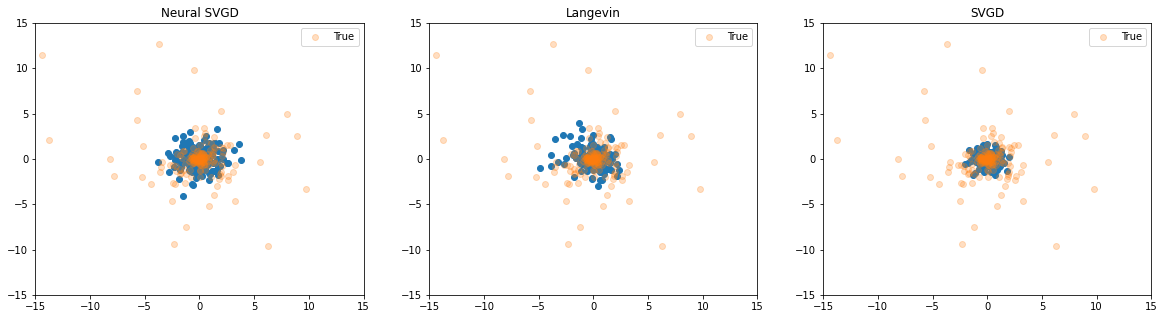

In [36]:
idx = np.array([0, 1])
plot_projection(idx)

In [10]:
# plt.plot(neural_particles.rundata["training_std"]);

### animate projection

In [11]:
idx = np.array([1, -1])

In [12]:
trajectory = neural_particles.rundata["particles"]
trajectory = np.array([t.training for t in trajectory])
trajectory_projected = trajectory[:, :, idx]


In [13]:
# %matplotlib widget
# lims = (-15, 15)
# fig, ax = plt.subplots(figsize=[8,8])
# ax.scatter(*np.rollaxis(target.sample(n_particles)[:, idx], 1), label="True", alpha=0.25)
# ax.set(xlim=lims, ylim=lims)
# plot.animate_array(trajectory_projected, fig, ax)

# Metric

In [4]:
import kernels

In [5]:
rbf = kernels.get_rbf_kernel(1.)
funnel = kernels.get_funnel_kernel(1.)
mix = lambda x, y: rbf(x, y) + funnel(x, y)

kernel_matrix = vmap(vmap(funnel, (0, None)), (None, 0))

def null_diagonal(matrix):
    """matrix is an (n,n) array.
    output: same matrix with zeros along diagonal"""
    n = matrix.shape[0]
    trace_indices = [list(range(n))]*2
    matrix = index_update(matrix, trace_indices, 0)
    return matrix


@jit
def mmd(xs, ys):
    n = xs.shape[0]
    assert n == ys.shape[0]
    kxx = null_diagonal(kernel_matrix(xs, xs))
    kyy = null_diagonal(kernel_matrix(ys, ys))
    kxy = kernel_matrix(xs, ys)
    return np.sum(kxx + kyy) / (n*(n-1)) - 2 * np.mean(kxy)

In [6]:
da = distributions.Gaussian(0, 1)
db = distributions.Gaussian(0, 2)

In [7]:
key, keya, keyb = random.split(key, 3)
xs = da.sample(1000, keya)
ys = db.sample(1000, keyb)
mmd(xs, ys)

DeviceArray(0.02537544, dtype=float32)

# Sweep

In [8]:
n_steps = 300
particle_lr = 1e-2
learner_lr = 1e-2

In [9]:
def sample(d, key, n_particles):
    target = distributions.Funnel(d)
    proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
    funnel_setup = distributions.Setup(target, proposal)

    key, subkey = random.split(key)
    neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., patience=0, learner_lr=learner_lr)
    svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
    sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)
    
    return (neural_particles, svgd_particles, sgld_particles), (neural_learner, svgd_gradient, sgld_gradient)

In [10]:
def get_mmds(particle_list, ys):
    mmds = []
    for xs in [p.particles.training for p in particle_list]:
        mmds.append(mmd(xs, ys))
    return mmds

In [11]:
mmd_sweep = []
key, subkey = random.split(key)
n_particles = 500

In [15]:
for d in tqdm(range(2, 40)):
    key, subkey = random.split(key)
    particles, gradients = sample(d, subkey, n_particles)
    target = distributions.Funnel(d)
    key, subkey = random.split(key)
    ys = target.sample(n_particles, subkey)
    mmds = get_mmds(particles, ys)
    mmd_sweep.append(mmds)

100%|██████████| 38/38 [2:43:11<00:00, 257.68s/it]


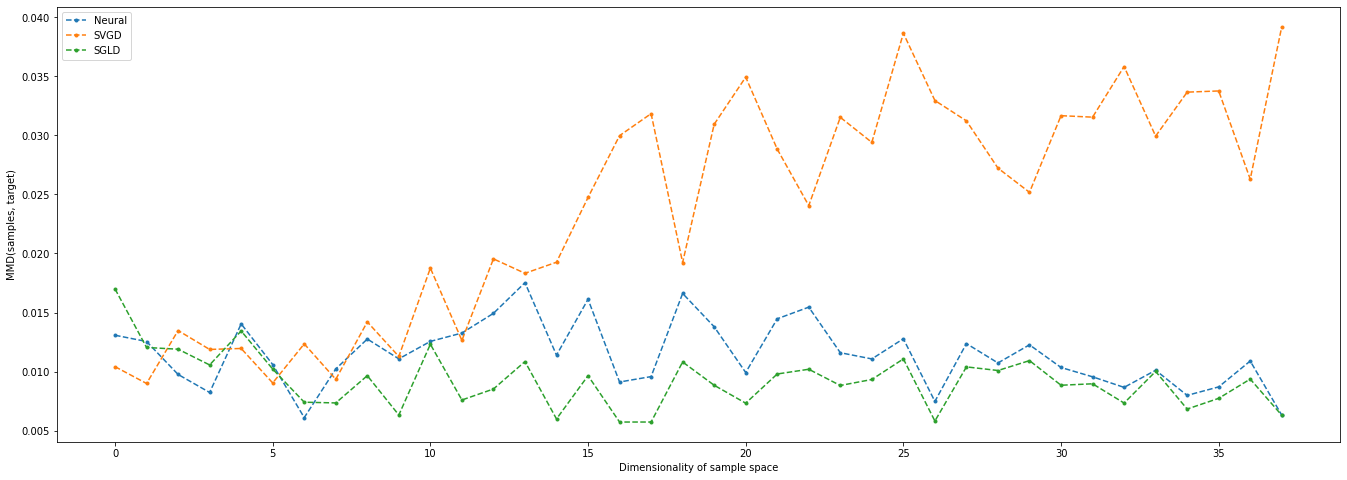

In [16]:
plt.subplots(figsize=[23, 8])
names = "Neural SVGD SGLD".split()
lines = plt.plot(mmd_sweep, "--.")
for name, line in zip(names, lines):
    line.set_label(name)
    
plt.ylabel("MMD(samples, target)")
plt.xlabel("Dimensionality of sample space")
plt.legend()

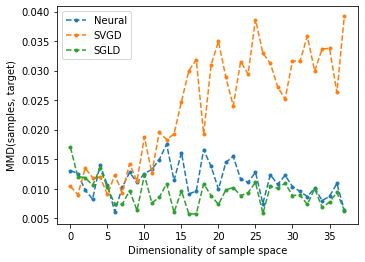

In [18]:
plt.subplots(figsize=printsize)
names = "Neural SVGD SGLD".split()
lines = plt.plot(mmd_sweep, "--.")
for name, line in zip(names, lines):
    line.set_label(name)
plt.legend()
plt.ylabel("MMD(samples, target)")
plt.xlabel("Dimensionality of sample space")
plt.savefig(figure_path + "funnel-dimension-sweep.pgf")

## plots

In [21]:
idx

DeviceArray([ 0, -1], dtype=int32)

(500, 39)
(500, 39)
(500, 39)


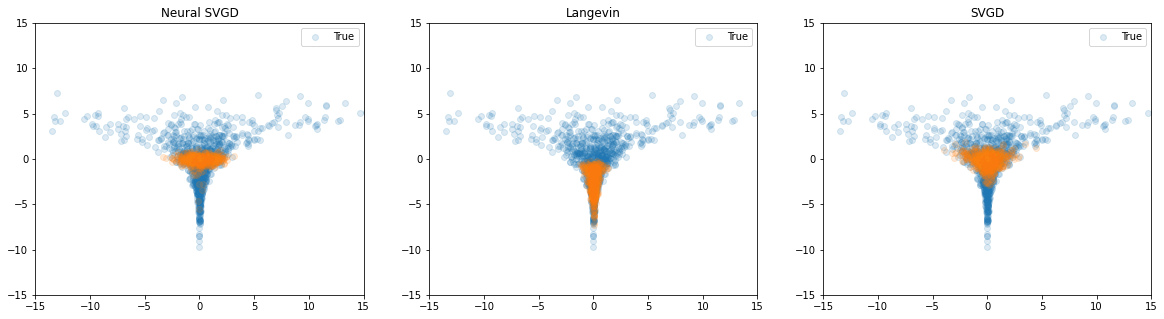

In [28]:
%matplotlib inline
lims=(-15, 15)
def plot_projection(idx):
    true_samples = target.sample(1000)
    sample_list = [p.particles.training for p in particles]
    fig, axs = plt.subplots(1, 3, figsize=[20, 5])
    titles = ("Neural SVGD", "Langevin", "SVGD")
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        print(samples.shape)
        ax.scatter(*np.rollaxis(true_samples[:, idx], 1), alpha=0.15, label="True")
        ax.scatter(*np.rollaxis(samples[:, idx], 1), alpha=0.15)
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

idx = np.array([34, -1])
plot_projection(idx)